In [95]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy import stats

import obspy.geodetics.flinnengdahl as flinnengdahl
fe = flinnengdahl.FlinnEngdahl()

In [96]:
def myround(x, base=5):
    return base * round(x/base)

In [97]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined.csv')

In [98]:
def get_stf(scardec_name, wanted_type = 'fctopt'):
    db = combined[combined['scardec_name']==scardec_name]

    time = []
    momentrate = []

    event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
    starts = [n for n, l in enumerate(event) if l.startswith(wanted_type)]
    with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
        lines = f.read().splitlines()

    lines = lines[2:]
    for line in lines:
        split = line.split(' ')
        split = [s for s in split if s not in ['', ' ', '\n']]
        time.append(float(split[0]))
        momentrate.append(float(split[1]))

    momentrate = np.array(momentrate)
    return momentrate, time, db

In [99]:
def get_mag(scardec_name):
    db = combined[combined['scardec_name']==scardec_name]
    mag = db['scardec_magnitude'].values[0]
    return mag

def get_date(scardec_name):
    db = combined[combined['scardec_name']==scardec_name]
    year = db['year'].values[0]
    month = db['month'].values[0]
    day = db['day'].values[0]
    return year, month, day

In [100]:
# looks for time value of root
def f3(end_time, total_moment, time_opt, momentrate_opt, start, points_before_zero, proportion = 0.1):
    dx = time_opt[1]-time_opt[0]
    end_window = (end_time/dx)+points_before_zero
    end = int(np.floor(end_window))
    if start == end:
        end += 1
    short = scipy.integrate.simpson(momentrate_opt[start:end], dx = dx)
    return short-(total_moment*proportion)

In [101]:
def bootstrap(data, n=1000, proportion = 1):
    """Bootstrap resampling of data.

    Args:
        data: 1D array of data to be resampled.
        n: number of resamples to take.

    Returns:
        resampled data.
    """

    rng = np.random.default_rng()

    resampled_data = rng.choice(data, (n, int(len(data)*proportion)), replace = True)

    return resampled_data

In [102]:
def convert_fe_subdivisions_to_regions(subdivision):
    final_values = [17, 29, 46, 52, 71, 83, 101, 142, 146, 157, 168, 179, 182, 189,
                    195, 208, 210, 216, 230, 241, 247, 260, 272, 293, 301, 319, 325,
                    334, 356, 375, 401, 414, 437, 527, 531, 549, 587, 610, 632, 655,
                    666, 682, 692, 699, 702, 708, 712, 720, 726, 729]

    if subdivision < 730:
        for index, max_value in enumerate(final_values):
            if subdivision <= max_value:
                return index+1
    else:
        if subdivision == 730:
            return 5
        elif subdivision == 731:
            return 7
        elif subdivision == 732:
            return 10
        elif subdivision in [733, 734, 735, 736, 737]:
            return 25
        elif subdivision in [738, 739]:
            return 32
        elif subdivision in [740, 741, 742]:
            return 33
        elif subdivision in [743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755]:
            return 37
        elif subdivision == 756:
            return 43
        elif subdivision == 757:
            return 44
        else:
            return None


In [103]:
proportions_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

all_durations = []
all_root_times = []
all_moments = []
all_relative_root_times = []

results_db = pd.DataFrame(columns = ['scardec_name', 'magnitude', 'int_magnitude', 'year', 'month', 'day', 'latitude', 'longitude', 'depth', 'FE', 'region', '10', '20', '30', '40', '50', '60', '70', '80', '90'])

colors = {'10': 'dodgerblue',
          '20': 'darkorange',
          '30': 'green',
          '40': 'red',
          '50': 'purple',
          '60': 'blue',
          '70': 'orange',
          '80': 'green',
          '90': 'red'}

for scardec_name in os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec'):
    #print(scardec_name)

    db = combined[combined['scardec_name']==scardec_name]
    momentrate_opt, time_opt, db = get_stf(scardec_name, wanted_type = 'fctmoy')

    not_zero = np.where(momentrate_opt > 0)[0]

    dx = time_opt[1]-time_opt[0]

    start = min(not_zero)
    end = max(not_zero)
    points_before_zero = abs(min(time_opt)/dx)

    duration = time_opt[end] - time_opt[start]

    start_time = time_opt[start]
    end_time = time_opt[end]

    total_moment = scipy.integrate.simpson(momentrate_opt[start:end], dx = time_opt[1]-time_opt[0])

    relative_root_times = []
    for proportion in proportions_list:
        root, r = scipy.optimize.bisect(f3,
                                        start_time+dx,
                                        end_time,
                                        rtol = 1e-6,
                                        full_output = True,
                                        args = (total_moment,
                                                time_opt,
                                                momentrate_opt,
                                                start,
                                                points_before_zero,
                                                proportion,))

        root_idx = np.floor(root/dx)
        root_time = root_idx*dx
        relative_root_times.append((root_time-start_time)/duration)
    mags = get_mag(scardec_name)
    int_mags = int(mags)

    fe_region = fe.get_number(db['longitude'].values[0], db['latitude'].values[0])

    region = convert_fe_subdivisions_to_regions(fe_region)

    list_for_database = [scardec_name, mags, int_mags, *get_date(scardec_name), db['latitude'].values[0], db['longitude'].values[0], db['depth'].values[0], fe_region, region, *relative_root_times]
    results_db.loc[len(results_db)] = list_for_database


In [104]:
results_10 = pd.DataFrame(columns = ['scardec_name', 'magnitude', 'int_magnitude', 'year' ,'month', 'day', 'region', '0_10', '10_20', '20_30', '30_40', '40_50', '50_60', '60_70', '70_80', '80_90', '90_100'])

results_10['scardec_name'] = results_db['scardec_name']
results_10['magnitude'] = results_db['magnitude']
results_10['int_magnitude'] = results_db['int_magnitude']
results_10['year'] = results_db['year']
results_10['month'] = results_db['month']
results_10['day'] = results_db['day']
results_10['region'] = results_db['region']

results_10['0_10'] = results_db['10']
results_10['10_20'] = results_db['20'] - results_db['10']
results_10['20_30'] = results_db['30'] - results_db['20']
results_10['30_40'] = results_db['40'] - results_db['30']
results_10['40_50'] = results_db['50'] - results_db['40']
results_10['50_60'] = results_db['60'] - results_db['50']
results_10['60_70'] = results_db['70'] - results_db['60']
results_10['70_80'] = results_db['80'] - results_db['70']
results_10['80_90'] = results_db['90'] - results_db['80']
results_10['90_100'] = 1 - results_db['90']


In [105]:
results_10.sort_values(by = 'year', inplace = True, ignore_index=True)

In [106]:
ks_regions = pd.DataFrame(columns = ['1', '2','3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50'])
for region1 in np.arange(1, 51, 1):
    region_results_1 = results_10[results_10['region'] == region1]
    if len(region_results_1) >= 1:
        region2_results = []
        for region2 in np.arange(1, 51, 1):
            region_results_2 = results_10[results_10['region'] == region2]
            if len(region_results_2) >= 1:
                #print(region1, region2, stats.kstest(region_results_1['0_10'], region_results_2['0_10']).pvalue)
                region2_results.append(stats.kstest(region_results_1['0_10'], region_results_2['0_10']).pvalue)
            else:
                region2_results.append(None)

        ks_regions.loc[region1] = region2_results



In [107]:
ks_regions.to_csv('/home/earthquakes1/homes/Rebecca/phd/stf/code/grouping_events/ks_regions.csv')

In [108]:
for r in np.arange(0, 50, 1):
    print(r, len(results_db[results_db['region'] == r]))

0 0
1 201
2 33
3 34
4 15
5 98
6 80
7 32
8 317
9 5
10 85
11 35
12 264
13 113
14 289
15 303
16 161
17 34
18 126
19 367
20 56
21 82
22 159
23 160
24 263
25 25
26 50
27 23
28 15
29 57
30 57
31 19
32 104
33 95
34 5
35 0
36 2
37 21
38 4
39 9
40 23
41 38
42 13
43 23
44 2
45 6
46 118
47 12
48 56
49 0


two-sided: The null hypothesis is that the two distributions are identical, F(x)=G(x) for all x; the alternative is that they are not identical.

We choose a confidence level of 95%; that is, we will reject the null hypothesis in favor of the alternative if the p-value is less than 0.05.

all have a p-value < 0.05

thus we reject H0, the distributions are not identical


In [109]:
bin_list = np.arange(0, 1.01, 0.01)

Text(0.5, 1.0, '0.0076234205278492215')

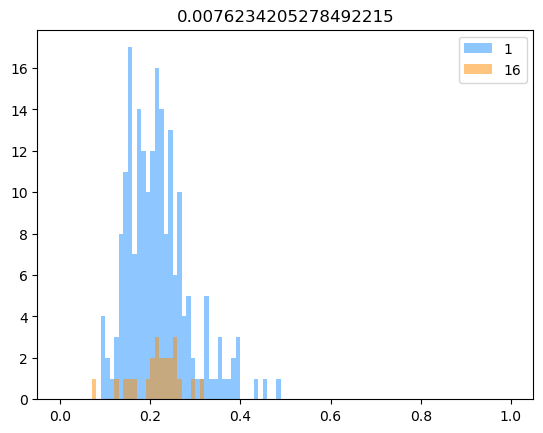

In [110]:
plt.hist(results_10[results_10['region'] == 1]['0_10'], bins = bin_list, alpha = 0.5, color = 'dodgerblue', label = '1')
plt.hist(results_10[results_10['region'] == 43]['0_10'], bins = bin_list, alpha = 0.5, color = 'darkorange', label = '16')
plt.legend()
plt.title(stats.kstest(results_10[results_10['region'] == 16]['0_10'], results_10[results_10['region'] == 1]['0_10']).pvalue)

0.24472814530042064
0.25459360450415736
0.08639828996309593
0.09501209128683111


Text(0.5, 1.0, '0.03309808308353394')

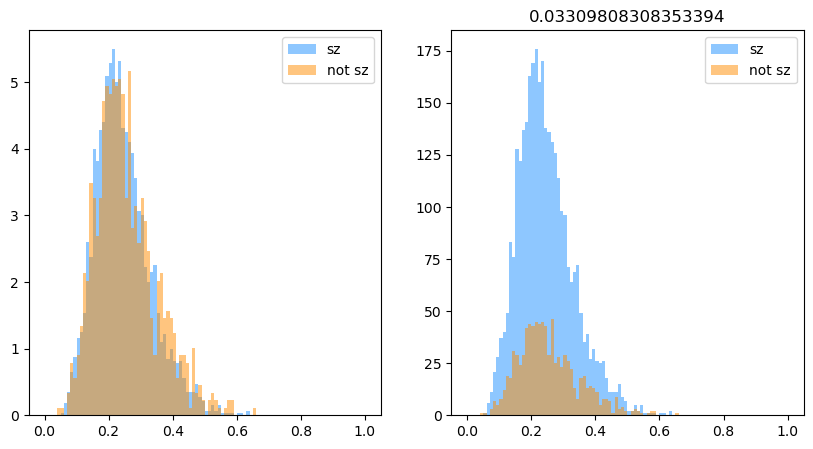

In [111]:
regions_with_sz = [1,2,4,5,6,8,9,17,19,20,21,22,46,24,16,15,23, 11, 7, 18, 14, 12]

fig, axs = plt.subplots(1, 2, figsize = (10, 5))

axs[0].hist(results_10[results_10['region'].isin(regions_with_sz)]['0_10'], bins = bin_list, alpha = 0.5, color = 'dodgerblue', label = 'sz', density = True)
axs[0].hist(results_10[~results_10['region'].isin(regions_with_sz)]['0_10'], bins = bin_list, alpha = 0.5, color = 'darkorange', label = 'not sz', density = True)
axs[0].legend()

axs[1].hist(results_10[results_10['region'].isin(regions_with_sz)]['0_10'], bins = bin_list, alpha = 0.5, color = 'dodgerblue', label = 'sz', density = False)
axs[1].hist(results_10[~results_10['region'].isin(regions_with_sz)]['0_10'], bins = bin_list, alpha = 0.5, color = 'darkorange', label = 'not sz', density = False)
axs[1].legend()


print(results_10[results_10['region'].isin(regions_with_sz)]['0_10'].mean())
print(results_10[~results_10['region'].isin(regions_with_sz)]['0_10'].mean())
print(results_10[results_10['region'].isin(regions_with_sz)]['0_10'].std())
print(results_10[~results_10['region'].isin(regions_with_sz)]['0_10'].std())
plt.title(stats.kstest(results_10[results_10['region'].isin(regions_with_sz)]['0_10'], results_10[~results_10['region'].isin(regions_with_sz)]['0_10']).pvalue)



In [112]:
results_10.columns[6:]

Index(['region', '0_10', '10_20', '20_30', '30_40', '40_50', '50_60', '60_70',
       '70_80', '80_90', '90_100'],
      dtype='object')

0.24472814530042067
0.2545936045041574
0.08639828996309593
0.09501209128683111


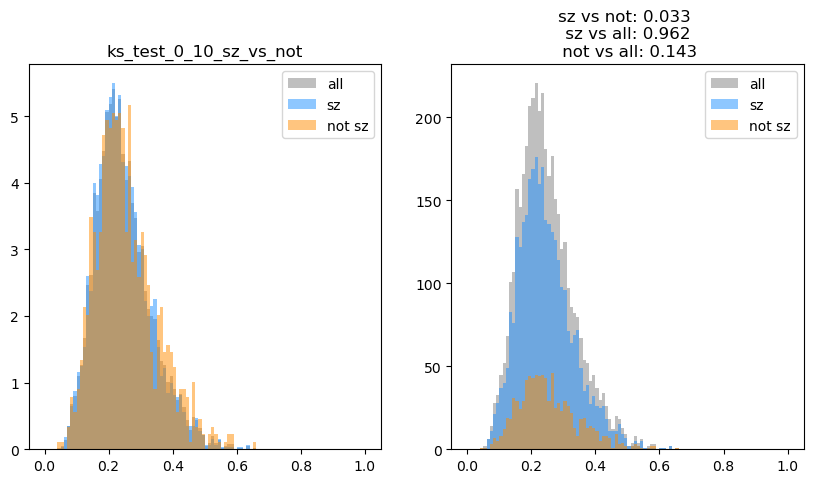

0.056778937078332585
0.05967618358192023
0.02872469134494405
0.033105091542395895


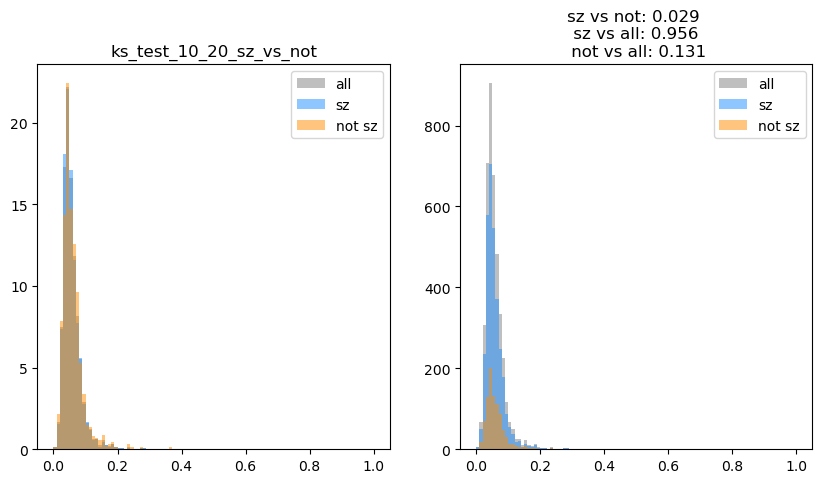

0.043712468581959006
0.045687661911919135
0.02113647868670872
0.024458359442854422


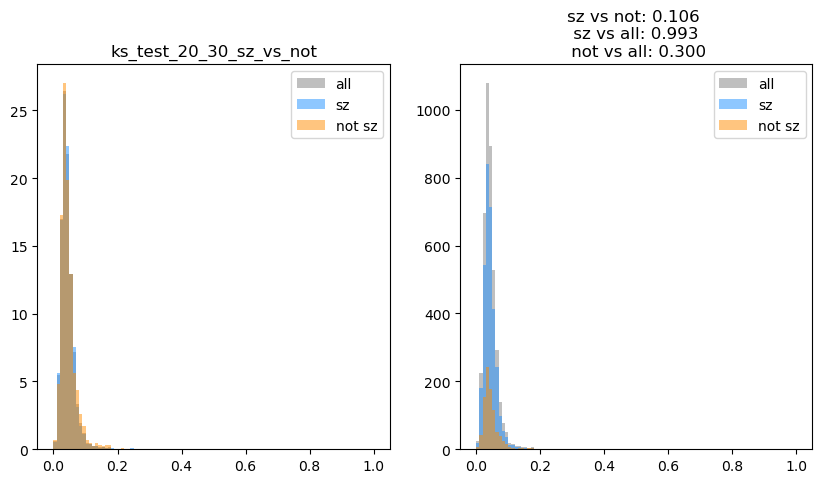

0.04034114363797704
0.04196558534067408
0.022035929231868576
0.02707694490964844


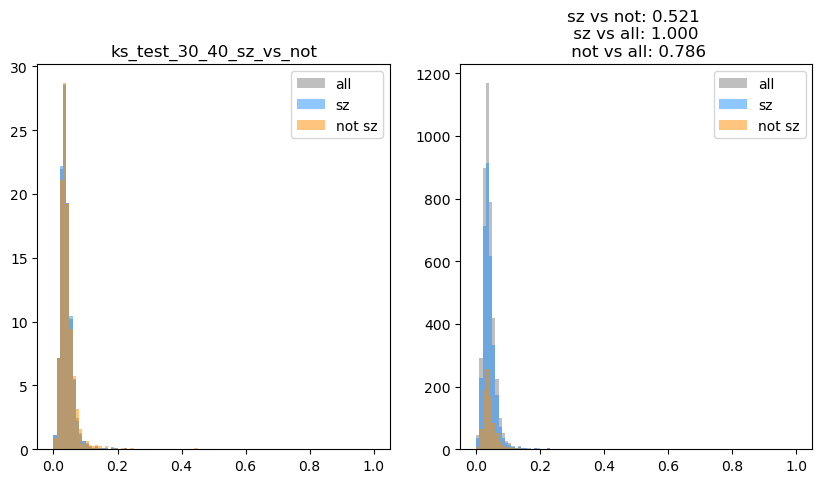

0.04182959451161544
0.04318168548478967
0.027182102286656202
0.032166365036268525


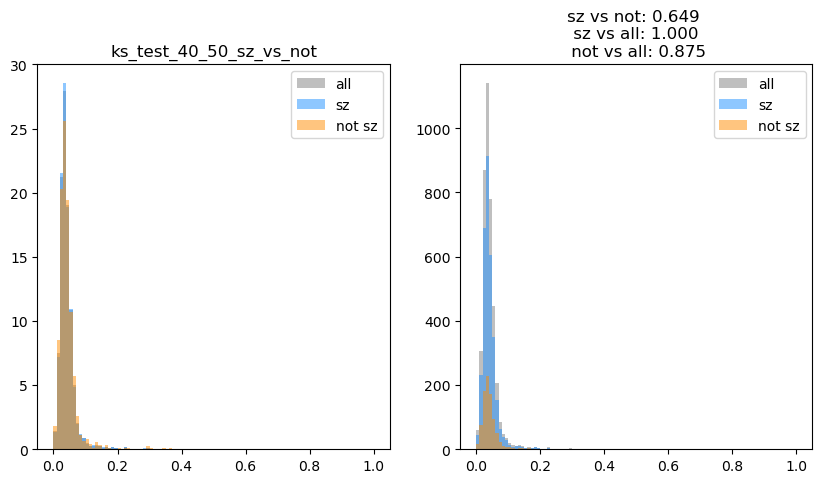

0.04653153562818885
0.04698478225987951
0.03465695896734039
0.03664249302139568


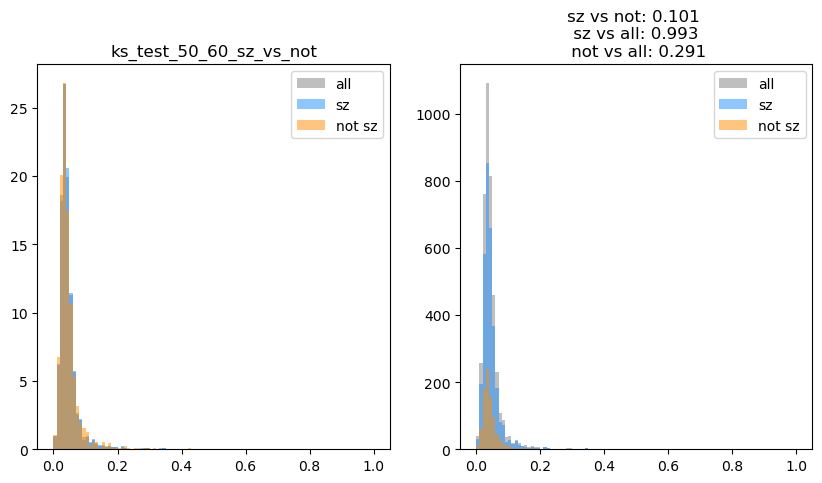

0.05659487471715781
0.05329973869394379
0.050353633265509304
0.04331217509359445


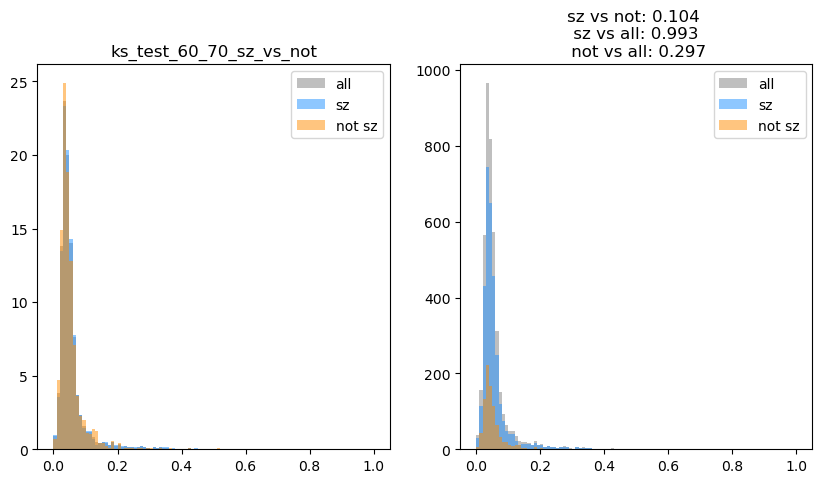

0.06644676695950365
0.06561872731801592
0.05387746587177996
0.05611311787222609


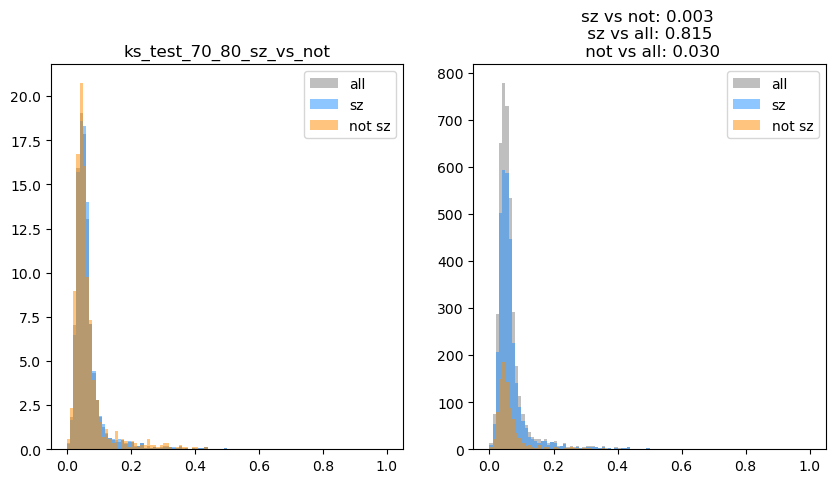

0.08461917088318667
0.08218049073853641
0.04538941513670901
0.04653004788198201


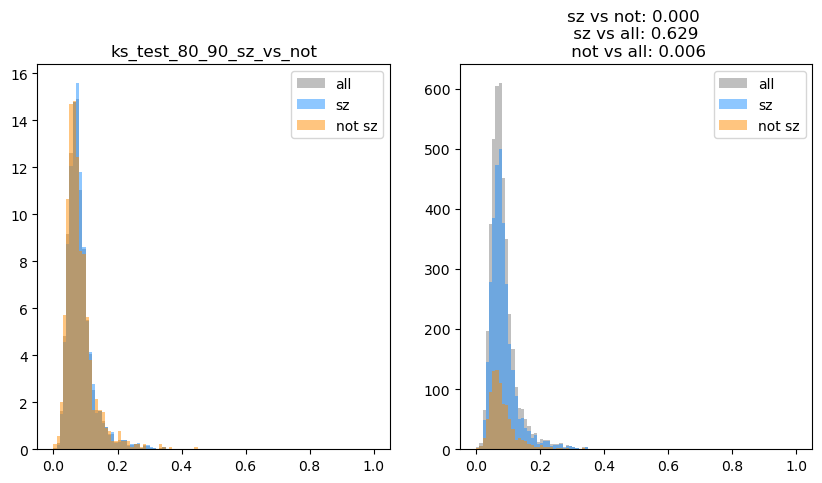

0.31841736270165827
0.3068115401661639
0.12284561341889949
0.1251145200026801


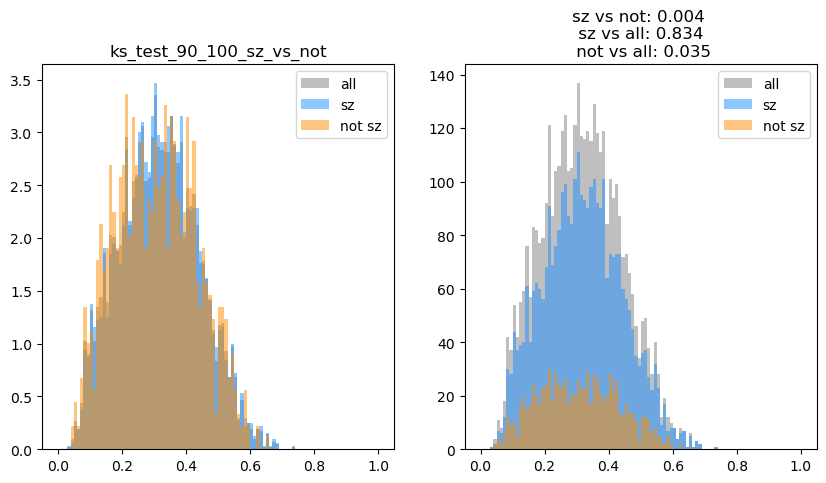

In [133]:
regions_with_sz = [1,2,4,5,6,8,9,17,19,20,21,22,46,24,16,15,23, 11, 7, 18, 14, 12]

for window in results_10.columns[7:]:
    fig, axs = plt.subplots(1, 2, figsize = (10, 5))

    axs[0].hist(results_10[window], bins = bin_list, alpha = 0.5, color = 'grey', label = 'all', density = True)
    axs[0].hist(results_10[results_10['region'].isin(regions_with_sz)][window], bins = bin_list, alpha = 0.5, color = 'dodgerblue', label = 'sz', density = True)
    axs[0].hist(results_10[~results_10['region'].isin(regions_with_sz)][window], bins = bin_list, alpha = 0.5, color = 'darkorange', label = 'not sz', density = True)
    axs[0].legend()

    axs[1].hist(results_10[window], bins = bin_list, alpha = 0.5, color = 'grey', label = 'all', density = False)
    axs[1].hist(results_10[results_10['region'].isin(regions_with_sz)][window], bins = bin_list, alpha = 0.5, color = 'dodgerblue', label = 'sz', density = False)
    axs[1].hist(results_10[~results_10['region'].isin(regions_with_sz)][window], bins = bin_list, alpha = 0.5, color = 'darkorange', label = 'not sz', density = False)
    axs[1].legend()


    print(results_10[results_10['region'].isin(regions_with_sz)][window].mean())
    print(results_10[~results_10['region'].isin(regions_with_sz)][window].mean())
    print(results_10[results_10['region'].isin(regions_with_sz)][window].std())
    print(results_10[~results_10['region'].isin(regions_with_sz)][window].std())

    ks_sz_not = stats.kstest(results_10[results_10['region'].isin(regions_with_sz)][window], results_10[~results_10['region'].isin(regions_with_sz)][window])
    ks_sz_all = stats.kstest(results_10[results_10['region'].isin(regions_with_sz)][window], results_10[window])
    ks_not_all = stats.kstest(results_10[~results_10['region'].isin(regions_with_sz)][window], results_10[window])

    axs[0].set_title(f'ks_test_{window}_sz_vs_not')
    axs[1].set_title(f'sz vs not: {ks_sz_not.pvalue:.3f} \n sz vs all: {ks_sz_all.pvalue:.3f} \n not vs all: {ks_not_all.pvalue:.3f}')

    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/grouping_events/ks_test_{window}_sz_vs_not.png')
    plt.show()
    plt.close()

In [114]:
results_10

,scardec_name,magnitude,int_magnitude,year,month,day,region,0_10,10_20,20_30,30_40,40_50,50_60,60_70,70_80,80_90,90_100
0,FCTs_19921111_212614_ANDREANOF_ISLANDS__ALEUTI...,6.144,6,1992,11,11,1,0.186441,0.029661,0.025424,0.033898,0.038136,0.063559,0.131356,0.169492,0.072034,0.250000
1,FCTs_19920305_143910_OFF_EAST_COAST_OF_KAMCHATKA,6.305,6,1992,3,5,19,0.230769,0.062937,0.055944,0.020979,0.027972,0.034965,0.027972,0.055944,0.097902,0.384615
2,FCTs_19920517_094919_MINDANAO__PHILIPPINES,6.990,6,1992,5,17,22,0.181467,0.057915,0.050193,0.042471,0.038610,0.038610,0.038610,0.046332,0.061776,0.444015
3,FCTs_19920307_015337_COSTA_RICA,6.485,6,1992,3,7,6,0.268966,0.055172,0.048276,0.034483,0.027586,0.048276,0.048276,0.062069,0.089655,0.317241
4,FCTs_19921006_102822_NEW_BRITAIN_REGION__P.N.G,6.103,6,1992,10,6,15,0.185393,0.044944,0.033708,0.028090,0.039326,0.039326,0.050562,0.067416,0.067416,0.443820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4084,FCTs_20220930_192840_NORTHERN_SUMATRA__INDONESIA,5.777,5,2022,9,30,46,0.143498,0.044843,0.116592,0.062780,0.044843,0.035874,0.026906,0.143498,0.116592,0.264574
4085,FCTs_20220505_082115_PHILIPPINE_ISLANDS_REGION,6.072,6,2022,5,5,22,0.162791,0.046512,0.023256,0.027907,0.032558,0.027907,0.037209,0.074419,0.260465,0.306977
4086,FCTs_20220419_043343_TONGA_ISLANDS,6.104,6,2022,4,19,12,0.285714,0.054945,0.054945,0.032967,0.032967,0.032967,0.043956,0.043956,0.065934,0.351648
4087,FCTs_20220608_005546_PERU-BRAZIL_BORDER_REGION,6.498,6,2022,6,8,8,0.240741,0.046296,0.027778,0.018519,0.046296,0.018519,0.037037,0.027778,0.055556,0.481481


0.24472814530042064
0.25459360450415736
0.08639828996309593
0.09501209128683111


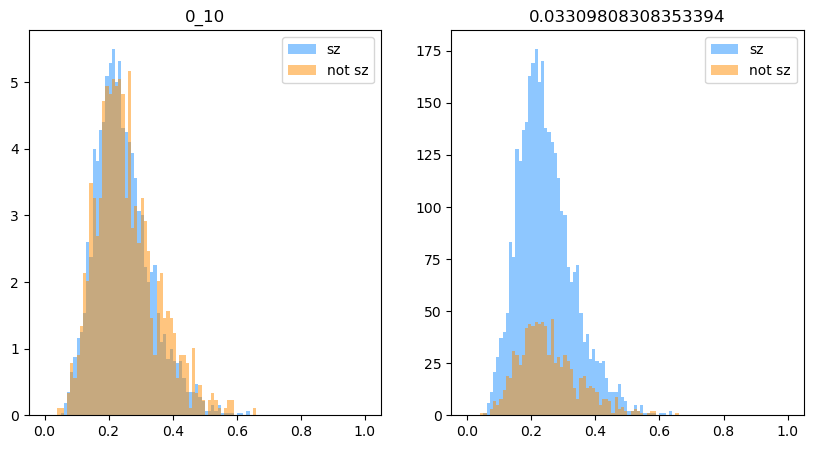

0.056778937078332585
0.05967618358192023
0.028724691344944046
0.033105091542395895


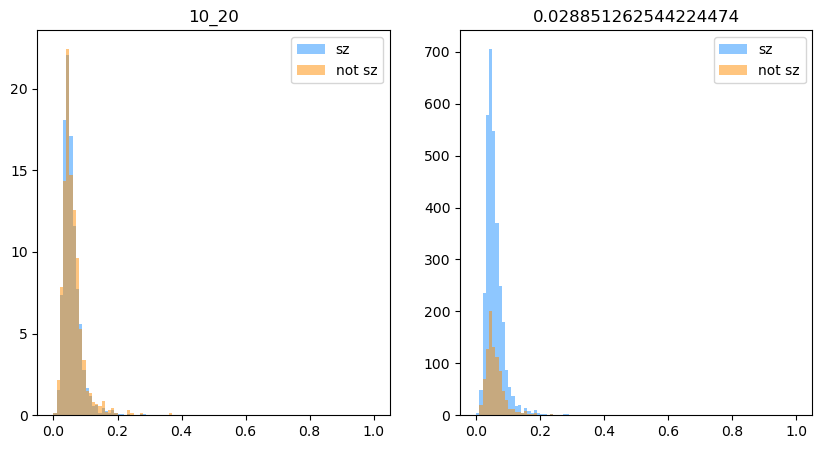

0.043712468581959006
0.045687661911919135
0.021136478686708725
0.024458359442854422


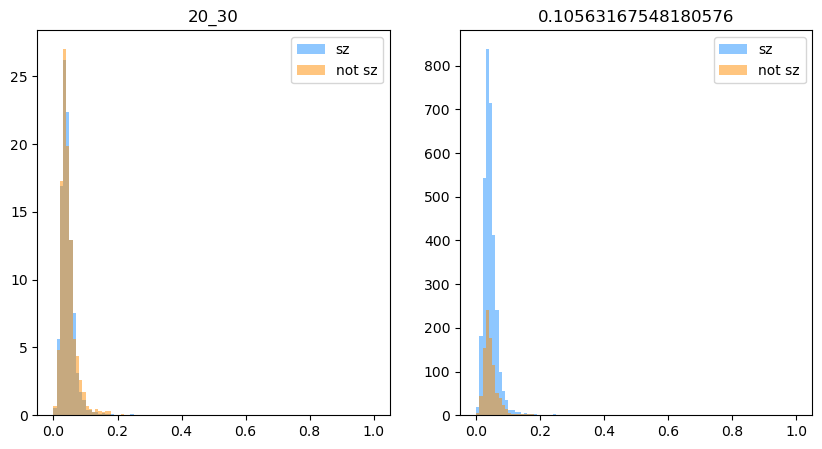

0.04034114363797704
0.04196558534067409
0.022035929231868576
0.02707694490964844


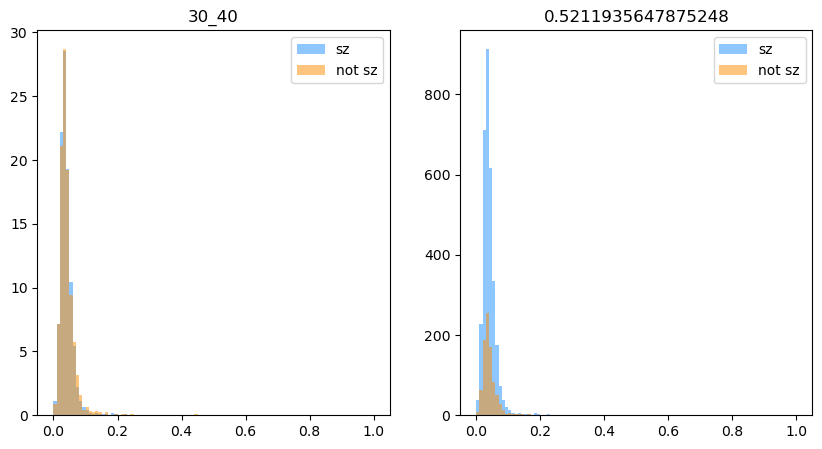

0.04182959451161544
0.043181685484789664
0.02718210228665621
0.032166365036268525


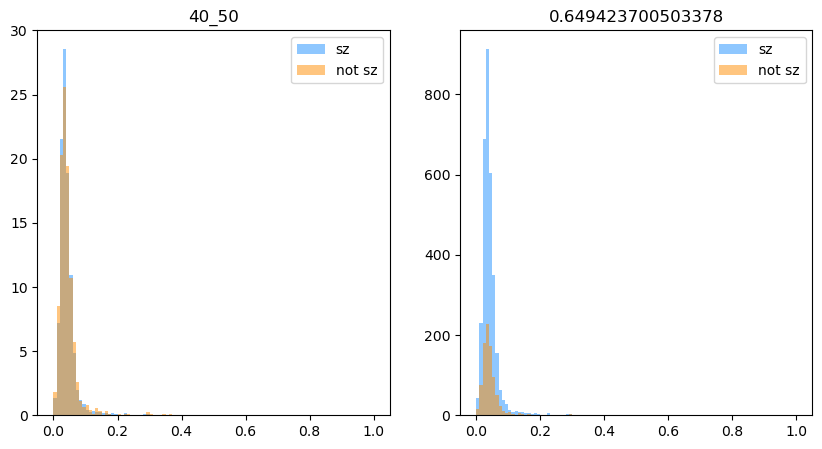

0.04653153562818885
0.04698478225987951
0.03465695896734039
0.03664249302139568


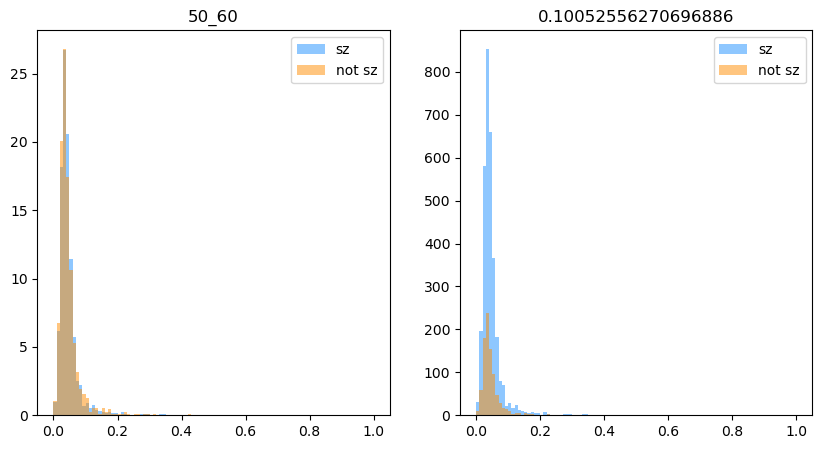

0.05659487471715781
0.0532997386939438
0.050353633265509325
0.04331217509359446


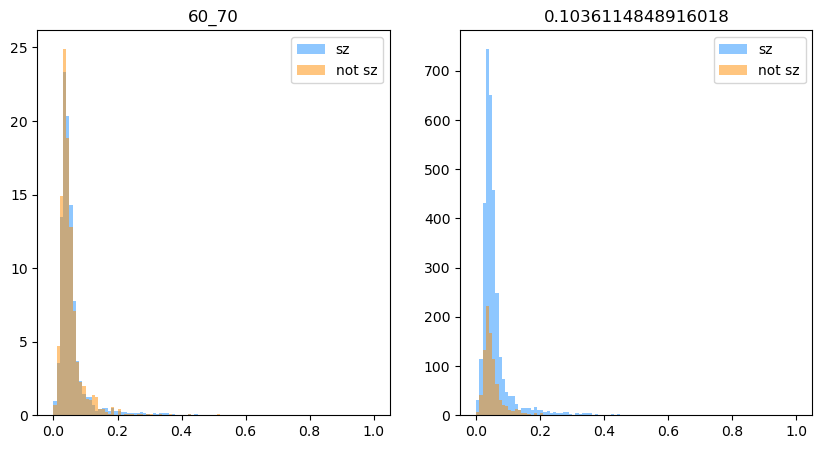

0.06644676695950365
0.06561872731801592
0.05387746587177994
0.056113117872226066


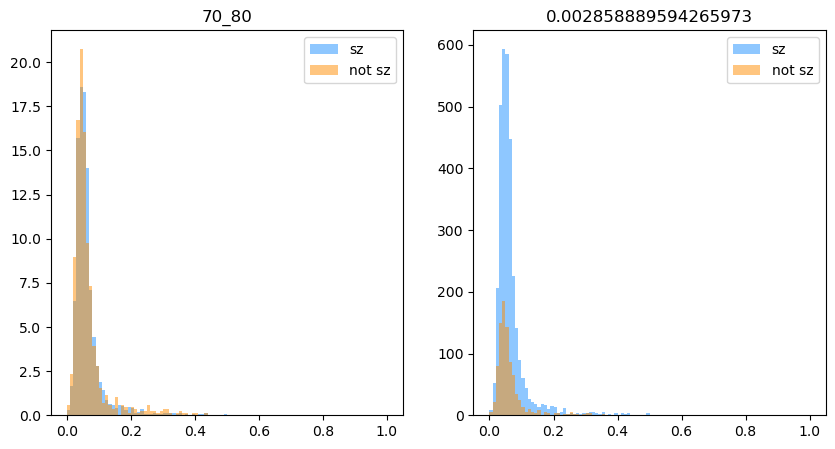

0.08461917088318668
0.08218049073853641
0.045389415136708994
0.04653004788198201


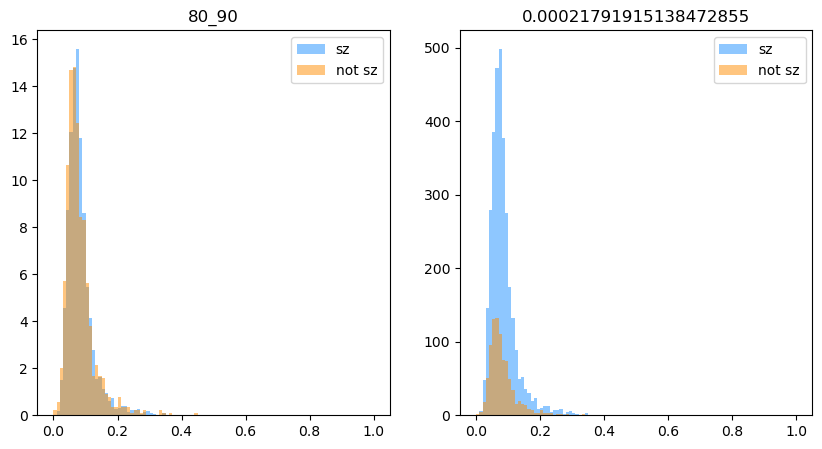

0.3184173627016583
0.30681154016616385
0.12284561341889952
0.1251145200026801


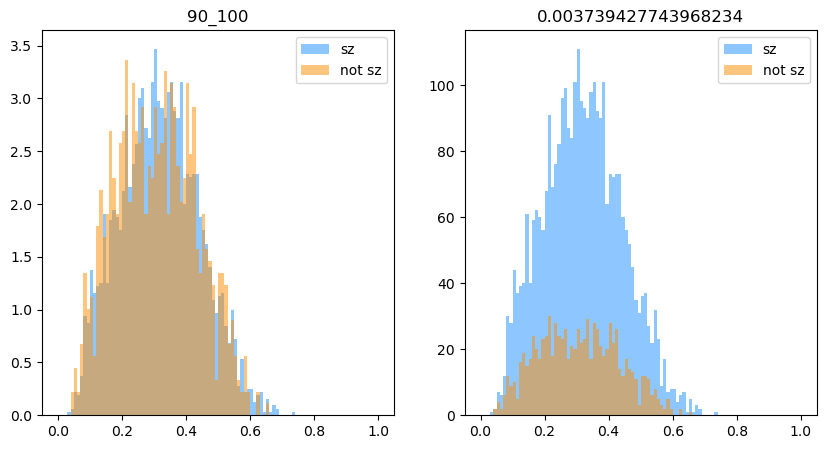

In [115]:
regions_with_sz = [1,2,4,5,6,8,9,17,19,20,21,22,46,24,16,15,23, 11, 7, 18, 14, 12]

for window in results_10.columns[7:]:
    fig, axs = plt.subplots(1, 2, figsize = (10, 5))

    axs[0].hist(results_10[results_10['region'].isin(regions_with_sz)][window], bins = bin_list, alpha = 0.5, color = 'dodgerblue', label = 'sz', density = True)
    axs[0].hist(results_10[~results_10['region'].isin(regions_with_sz)][window], bins = bin_list, alpha = 0.5, color = 'darkorange', label = 'not sz', density = True)
    axs[0].legend()
    axs[0].set_title(window)

    axs[1].hist(results_10[results_10['region'].isin(regions_with_sz)][window], bins = bin_list, alpha = 0.5, color = 'dodgerblue', label = 'sz', density = False)
    axs[1].hist(results_10[~results_10['region'].isin(regions_with_sz)][window], bins = bin_list, alpha = 0.5, color = 'darkorange', label = 'not sz', density = False)
    axs[1].legend()


    print(results_10[results_10['region'].isin(regions_with_sz)][window].mean())
    print(results_10[~results_10['region'].isin(regions_with_sz)][window].mean())
    print(results_10[results_10['region'].isin(regions_with_sz)][window].std())
    print(results_10[~results_10['region'].isin(regions_with_sz)][window].std())
    axs[1].set_title(stats.kstest(results_10[results_10['region'].isin(regions_with_sz)][window], results_10[~results_10['region'].isin(regions_with_sz)][window]).pvalue)

    plt.show()

In [116]:
results_10.sort_values(['year', 'month', 'day'], inplace = True, ignore_index=True)

In [117]:
results_10[results_10['region'].isin(regions_with_sz)]

,scardec_name,magnitude,int_magnitude,year,month,day,region,0_10,10_20,20_30,30_40,40_50,50_60,60_70,70_80,80_90,90_100
0,FCTs_19920120_133703_BONIN_ISLANDS__JAPAN_REGION,6.566,6,1992,1,20,18,0.270588,0.058824,0.023529,0.047059,0.035294,0.047059,0.070588,0.047059,0.082353,0.317647
1,FCTs_19920213_012913_VANUATU_ISLANDS,6.716,6,1992,2,13,14,0.330097,0.116505,0.140777,0.077670,0.053398,0.043689,0.038835,0.033981,0.043689,0.121359
2,FCTs_19920305_143910_OFF_EAST_COAST_OF_KAMCHATKA,6.305,6,1992,3,5,19,0.230769,0.062937,0.055944,0.020979,0.027972,0.034965,0.027972,0.055944,0.097902,0.384615
3,FCTs_19920307_015337_COSTA_RICA,6.485,6,1992,3,7,6,0.268966,0.055172,0.048276,0.034483,0.027586,0.048276,0.048276,0.062069,0.089655,0.317241
4,FCTs_19920313_160104_ANDREANOF_ISLANDS__ALEUTI...,6.415,6,1992,3,13,1,0.242188,0.039062,0.031250,0.031250,0.031250,0.046875,0.070312,0.046875,0.156250,0.304688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4083,FCTs_20221206_060748_SOUTH_OF_JAVA__INDONESIA,5.978,5,2022,12,6,24,0.377778,0.055556,0.044444,0.044444,0.044444,0.022222,0.044444,0.044444,0.044444,0.277778
4084,FCTs_20221208_005055_JAVA__INDONESIA,5.777,5,2022,12,8,24,0.353846,0.030769,0.030769,0.015385,0.030769,0.015385,0.030769,0.030769,0.046154,0.415385
4085,FCTs_20221211_143129_GUERRERO__MEXICO,5.996,5,2022,12,11,5,0.340000,0.080000,0.050000,0.030000,0.050000,0.040000,0.040000,0.060000,0.090000,0.220000
4086,FCTs_20221214_184026_RAT_ISLANDS__ALEUTIAN_ISL...,6.274,6,2022,12,14,1,0.280488,0.036585,0.024390,0.048780,0.036585,0.048780,0.048780,0.048780,0.060976,0.365854


In [118]:
results_10[~results_10['region'].isin(regions_with_sz)].iloc[445]

scardec_name     FCTs_20081213_084536_WESTERN_INDIAN-ANTARCTIC_...
magnitude                                                    5.921
int_magnitude                                                    5
year                                                          2008
month                                                           12
day                                                             13
region                                                          33
0_10                                                      0.319767
10_20                                                     0.040698
20_30                                                     0.046512
30_40                                                      0.02907
40_50                                                      0.02907
50_60                                                     0.040698
60_70                                                     0.145349
70_80                                                     0.15

In [119]:
regions_with_sz.sort()

In [120]:
regions_with_sz

[1,
 2,
 4,
 5,
 6,
 7,
 8,
 9,
 11,
 12,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 46]